# Analysis adjectives

In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from createDataset.params import *
import os
import json
import pandas as pd

In [2]:
LOCAL_PATH = "../data/"
ADJ_MALE = os.path.join(LOCAL_PATH, "count_male_adjectives.json")
ADJ_FEM = os.path.join(LOCAL_PATH, "count_female_adjectives.json")

In [3]:
# create the session
spark = SparkSession.builder.getOrCreate()
# create the context
sc = spark.sparkContext

most_common_adj_male = spark.read.json(ADJ_MALE)
most_common_adj_fem = spark.read.json(ADJ_FEM)

In [4]:
most_common_adj_male = most_common_adj_male.orderBy(desc("count"))
most_common_adj_male.show()

+----------+-----+
|adjectives|count|
+----------+-----+
|     right|59358|
|     large|38046|
|   popular|32918|
|   notable|29582|
|      best|28404|
|     major|28211|
|    active|26180|
|      high|24815|
|    famous|18211|
|successful|17535|
|      long|17157|
|     great|16970|
| prominent|16280|
| important|16050|
|      free|15042|
|    modern|14615|
|     civil|11679|
|  original|11091|
|   olympic| 9942|
|     minor| 9908|
+----------+-----+
only showing top 20 rows



In [5]:
most_common_adj_fem = most_common_adj_fem.orderBy(desc("count"))
most_common_adj_fem.show()

+-----------+-----+
| adjectives|count|
+-----------+-----+
|    popular| 8720|
|       best| 8010|
|    notable| 5832|
|      large| 5139|
|       high| 4924|
|    olympic| 4576|
|     active| 4430|
|       long| 4405|
|      major| 4050|
|      right| 3654|
| successful| 3305|
|     famous| 3302|
|competitive| 2864|
|      great| 2681|
|  prominent| 2456|
|   original| 2364|
|     modern| 2145|
|independent| 2118|
|      vocal| 1996|
| democratic| 1911|
+-----------+-----+
only showing top 20 rows



In [6]:
subjectivity_dictionary = {}
    
with open('../data/subjectivity_dictionary.json', 'r') as json_file:
    for item in eval(json_file.readline()):
        subjectivity_dictionary.update({item['word']: (item['strength'], item['subj'])})

In [7]:
def get_subjectivity(adj):
    return subjectivity_dictionary.get(adj)[1]

def get_strength(adj):
    return subjectivity_dictionary.get(adj)[0]

In [8]:
udf_get_subj = udf(get_subjectivity)
udf_get_strength = udf(get_strength)

most_common_adj_male = most_common_adj_male.withColumn("subjectivity", udf_get_subj("adjectives"))
most_common_adj_fem = most_common_adj_fem.withColumn("subjectivity", udf_get_subj("adjectives"))
most_common_adj_male = most_common_adj_male.withColumn("strength", udf_get_strength("adjectives"))
most_common_adj_fem = most_common_adj_fem.withColumn("strength", udf_get_strength("adjectives"))

In [9]:
most_common_adj_male.show()

+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|     right|59358|    positive|strongsubj|
|     large|38046|    positive|  weaksubj|
|   popular|32918|    positive|  weaksubj|
|   notable|29582|    positive|strongsubj|
|      best|28404|    positive|strongsubj|
|     major|28211|     neutral|  weaksubj|
|    active|26180|    positive|  weaksubj|
|      high|24815|     neutral|  weaksubj|
|    famous|18211|    positive|  weaksubj|
|successful|17535|    positive|  weaksubj|
|      long|17157|    negative|strongsubj|
|     great|16970|    positive|strongsubj|
| prominent|16280|    positive|  weaksubj|
| important|16050|    positive|  weaksubj|
|      free|15042|    positive|  weaksubj|
|    modern|14615|    positive|  weaksubj|
|     civil|11679|    positive|  weaksubj|
|  original|11091|    positive|  weaksubj|
|   olympic| 9942|     neutral|  weaksubj|
|     minor| 9908|     neutral|  weaksubj|
+----------

In [10]:
most_common_adj_fem.show()

+-----------+-----+------------+----------+
| adjectives|count|subjectivity|  strength|
+-----------+-----+------------+----------+
|    popular| 8720|    positive|  weaksubj|
|       best| 8010|    positive|strongsubj|
|    notable| 5832|    positive|strongsubj|
|      large| 5139|    positive|  weaksubj|
|       high| 4924|     neutral|  weaksubj|
|    olympic| 4576|     neutral|  weaksubj|
|     active| 4430|    positive|  weaksubj|
|       long| 4405|    negative|strongsubj|
|      major| 4050|     neutral|  weaksubj|
|      right| 3654|    positive|strongsubj|
| successful| 3305|    positive|  weaksubj|
|     famous| 3302|    positive|  weaksubj|
|competitive| 2864|    positive|  weaksubj|
|      great| 2681|    positive|strongsubj|
|  prominent| 2456|    positive|  weaksubj|
|   original| 2364|    positive|  weaksubj|
|     modern| 2145|    positive|  weaksubj|
|independent| 2118|    positive|  weaksubj|
|      vocal| 1996|     neutral|  weaksubj|
| democratic| 1911|    positive|

In [11]:
WIKI_MALE = os.path.join(LOCAL_PATH, "wikipedia_male_adjectives.json")
WIKI_FEM = os.path.join(LOCAL_PATH, "wikipedia_female_adjectives.json")

In [12]:
df_male = spark.read.json(WIKI_MALE)
df_fem = spark.read.json(WIKI_FEM)

In [13]:
def get_nb_adjs(list_adj):
    return len(list_adj)

In [14]:
udf_get_nb_adjs = udf(get_nb_adjs)

df_male = df_male.withColumn("nb-adjs", udf_get_nb_adjs("adjectives"))
df_fem = df_fem.withColumn("nb-adjs", udf_get_nb_adjs("adjectives"))

In [15]:
print("MALE")
df_male.agg(mean(col("nb-adjs")), stddev(col("nb-adjs"))).show()

print("FEMALE")
df_fem.agg(mean(col("nb-adjs")), stddev(col("nb-adjs"))).show()

MALE
+------------------+--------------------+
|      avg(nb-adjs)|stddev_samp(nb-adjs)|
+------------------+--------------------+
|2.1237752477189096|  1.9709265284971673|
+------------------+--------------------+

FEMALE
+------------------+--------------------+
|      avg(nb-adjs)|stddev_samp(nb-adjs)|
+------------------+--------------------+
|1.9298829401628141|   1.675424943708712|
+------------------+--------------------+



## Word cloud for the most common adjectives

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image

In [17]:
adj_male_dict = most_common_adj_male.select('adjectives', 'count').toPandas().set_index('adjectives').T.to_dict('records')
adj_female_dict = most_common_adj_fem.select('adjectives', 'count').toPandas().set_index('adjectives').T.to_dict('records')

In [18]:
# map subjectity of words to colors
word_to_color = dict()

for word in subjectivity_dictionary:
    if subjectivity_dictionary[word][1] == "positive":
        word_to_color[word] = 'forestgreen' 
    if subjectivity_dictionary[word][1] == "negative":
        word_to_color[word] = 'crimson' 
    if subjectivity_dictionary[word][1] == "neutral":
        word_to_color[word] = 'grey' 

def color_func(word, *args, **kwargs):
    try:
        color = word_to_color[word]
    except KeyError:
        color = '#000000' # black
    return color


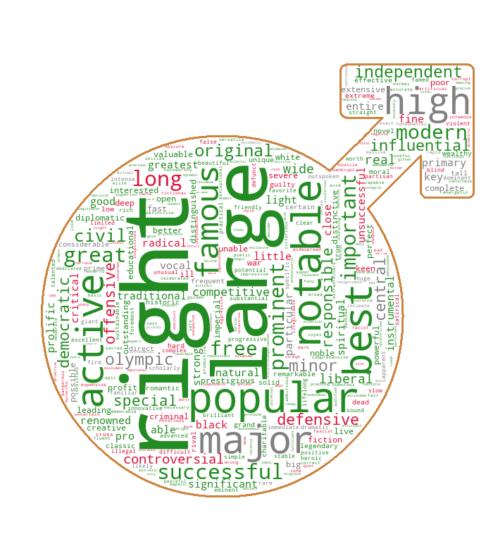

In [20]:
male_mask = np.array(Image.open("../data/male.png"))

wc = WordCloud(background_color="white", max_words=500, mask=male_mask, 
               contour_width=3, contour_color='peru', color_func=color_func)

# generate word cloud
wc.generate_from_frequencies(adj_male_dict[0])

# store to file
# wc.to_file(path.join(d, "male_adj.png"))

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

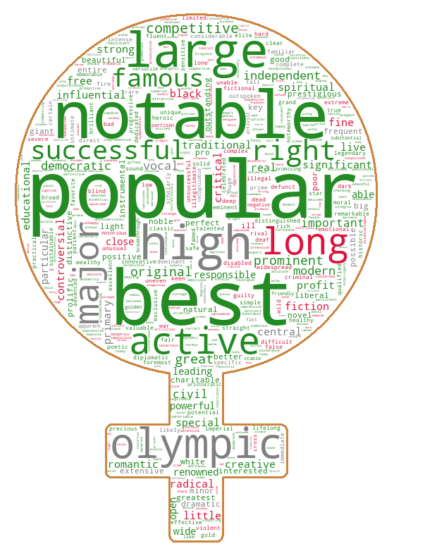

In [21]:
female_mask = np.array(Image.open("../data/female.png"))

wc = WordCloud(background_color="white", max_words=500, mask=female_mask, 
               contour_width=3, contour_color='peru', color_func=color_func)
# generate word cloud
wc.generate_from_frequencies(adj_female_dict[0])

# store to file
# wc.to_file(path.join(d, "female_adj.png"))

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

## Compare the strong positive/negative adjectives in the overviews

In [22]:
most_common_adj_male.show()

+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|     right|59358|    positive|strongsubj|
|     large|38046|    positive|  weaksubj|
|   popular|32918|    positive|  weaksubj|
|   notable|29582|    positive|strongsubj|
|      best|28404|    positive|strongsubj|
|     major|28211|     neutral|  weaksubj|
|    active|26180|    positive|  weaksubj|
|      high|24815|     neutral|  weaksubj|
|    famous|18211|    positive|  weaksubj|
|successful|17535|    positive|  weaksubj|
|      long|17157|    negative|strongsubj|
|     great|16970|    positive|strongsubj|
| prominent|16280|    positive|  weaksubj|
| important|16050|    positive|  weaksubj|
|      free|15042|    positive|  weaksubj|
|    modern|14615|    positive|  weaksubj|
|     civil|11679|    positive|  weaksubj|
|  original|11091|    positive|  weaksubj|
|   olympic| 9942|     neutral|  weaksubj|
|     minor| 9908|     neutral|  weaksubj|
+----------

In [23]:
overview_subjectivity_male = most_common_adj_male.groupBy('strength', 'subjectivity').\
agg(sum('count').alias('sum_')).orderBy(desc('sum_'))

overview_subjectivity_male = overview_subjectivity_male.replace('', 'None')
overview_subjectivity_male.show()


overview_subjectivity_female = most_common_adj_fem.groupBy('strength', 'subjectivity').\
agg(sum('count').alias('sum_')).orderBy(desc('sum_'))

overview_subjectivity_female = overview_subjectivity_female.replace('', 'None')
overview_subjectivity_female.show()

+----------+------------+------+
|  strength|subjectivity|  sum_|
+----------+------------+------+
|  weaksubj|    positive|504346|
|strongsubj|    positive|259329|
|  weaksubj|     neutral|167811|
|  weaksubj|    negative|139239|
|strongsubj|    negative|102235|
|strongsubj|     neutral| 10331|
|strongsubj|        both|     1|
+----------+------------+------+

+----------+------------+-----+
|  strength|subjectivity| sum_|
+----------+------------+-----+
|  weaksubj|    positive|88400|
|strongsubj|    positive|44759|
|  weaksubj|     neutral|30342|
|  weaksubj|    negative|22118|
|strongsubj|    negative|18729|
|strongsubj|     neutral| 2082|
+----------+------------+-----+



In [24]:
strong_adj_male = most_common_adj_male.where((col("strength") == "strongsubj")).\
groupBy('strength', 'subjectivity').agg({'count':'sum'}).\
where((col("subjectivity") == "positive") | (col("subjectivity") == "negative"))

strong_adj_male = strong_adj_male.\
withColumn("percentage", 100*strong_adj_male['sum(count)']/ most_common_adj_male.agg({'count':'sum'}).collect()[0][0])

strong_adj_male.show()


strong_adj_female = most_common_adj_fem.where((col("strength") == "strongsubj")).\
groupBy('strength', 'subjectivity').agg({'count':'sum'}).\
where((col("subjectivity") == "positive") | (col("subjectivity") == "negative"))

strong_adj_female = strong_adj_female.\
withColumn("percentage", 100*strong_adj_female['sum(count)']/ most_common_adj_fem.agg({'count':'sum'}).collect()[0][0])


strong_adj_female.show()

+----------+------------+----------+------------------+
|  strength|subjectivity|sum(count)|        percentage|
+----------+------------+----------+------------------+
|strongsubj|    negative|    102235| 8.639879252120355|
|strongsubj|    positive|    259329|21.915892273420255|
+----------+------------+----------+------------------+

+----------+------------+----------+------------------+
|  strength|subjectivity|sum(count)|        percentage|
+----------+------------+----------+------------------+
|strongsubj|    negative|     18729| 9.072809184711524|
|strongsubj|    positive|     44759|21.682410502349466|
+----------+------------+----------+------------------+



In [25]:
most_common_adj_male.where((col("strength") == "strongsubj") & (col("subjectivity") == 'positive')).show()

+-------------+-----+------------+----------+
|   adjectives|count|subjectivity|  strength|
+-------------+-----+------------+----------+
|        right|59358|    positive|strongsubj|
|      notable|29582|    positive|strongsubj|
|         best|28404|    positive|strongsubj|
|        great|16970|    positive|strongsubj|
|     greatest| 5928|    positive|strongsubj|
|     renowned| 4779|    positive|strongsubj|
|    spiritual| 4740|    positive|strongsubj|
|distinguished| 3679|    positive|strongsubj|
|  outstanding| 3434|    positive|strongsubj|
|     creative| 3001|    positive|strongsubj|
|     valuable| 2944|    positive|strongsubj|
|        noble| 2740|    positive|strongsubj|
|      perfect| 2658|    positive|strongsubj|
|   remarkable| 2398|    positive|strongsubj|
|     romantic| 2108|    positive|strongsubj|
|         true| 2051|    positive|strongsubj|
|        moral| 1980|    positive|strongsubj|
|        novel| 1949|    positive|strongsubj|
|      eminent| 1923|    positive|

In [26]:
most_common_adj_male.where((col("strength") == "strongsubj") & (col("subjectivity") == 'negative')).show()

+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|      long|17157|    negative|strongsubj|
|    little| 6328|    negative|strongsubj|
|   radical| 5772|    negative|strongsubj|
|  critical| 4617|    negative|strongsubj|
|      keen| 3594|    negative|strongsubj|
|    severe| 2672|    negative|strongsubj|
|   extreme| 2162|    negative|strongsubj|
|     false| 1844|    negative|strongsubj|
|     cross| 1361|    negative|strongsubj|
|   defunct| 1167|    negative|strongsubj|
|  partisan| 1156|    negative|strongsubj|
| satirical| 1137|    negative|strongsubj|
| notorious| 1097|    negative|strongsubj|
|   obscure| 1078|    negative|strongsubj|
|       bad| 1062|    negative|strongsubj|
|      lone| 1000|    negative|strongsubj|
|   corrupt|  804|    negative|strongsubj|
|aggressive|  783|    negative|strongsubj|
|   fascist|  764|    negative|strongsubj|
|    racist|  747|    negative|strongsubj|
+----------

In [27]:
strong_pos_male = most_common_adj_male \
                    .where((col("strength") == "strongsubj") & (col("subjectivity") == 'positive')) \
                    .count()

strong_neg_male = most_common_adj_male \
                    .where((col("strength") == "strongsubj") & (col("subjectivity") == 'negative')) \
                    .count()



In [28]:
from empath import Empath
lexicon = Empath()

In [2]:
common_adj_male_list = [str(row['adjectives']) for row in most_common_adj_male.collect()]
common_adj_female_list = [str(row['adjectives']) for row in most_common_adj_fem.collect()]

NameError: name 'most_common_adj_male' is not defined

In [53]:
adj_male_analyzed = lexicon.analyze(common_adj_male_list, normalize=True)
adj_female_analyzed = lexicon.analyze(common_adj_female_list, normalize=True)

In [1]:
sorted(adj_male_analyzed.items(), key=lambda kv: kv[1], reverse = True)[:10]

NameError: name 'adj_male_analyzed' is not defined

In [55]:
sorted(adj_female_analyzed.items(), key=lambda kv: kv[1], reverse = True)[:10]

[('emotional', 0.025),
 ('aggression', 0.022222222222222223),
 ('attractive', 0.020370370370370372),
 ('negative_emotion', 0.018055555555555554),
 ('sadness', 0.01712962962962963),
 ('beauty', 0.01712962962962963),
 ('hate', 0.016666666666666666),
 ('suffering', 0.016203703703703703),
 ('politeness', 0.01574074074074074),
 ('heroic', 0.014814814814814815),
 ('appearance', 0.014351851851851852),
 ('torment', 0.014351851851851852),
 ('timidity', 0.013888888888888888),
 ('optimism', 0.013425925925925926),
 ('wealthy', 0.012962962962962963),
 ('childish', 0.0125),
 ('weakness', 0.012037037037037037),
 ('ridicule', 0.012037037037037037),
 ('rage', 0.012037037037037037),
 ('strength', 0.012037037037037037),
 ('affection', 0.011574074074074073),
 ('cheerfulness', 0.011111111111111112),
 ('confusion', 0.010648148148148148),
 ('violence', 0.010648148148148148),
 ('dominant_personality', 0.010648148148148148),
 ('ugliness', 0.010648148148148148),
 ('pain', 0.010185185185185186),
 ('crime', 0.009